In [1]:
import torch
from torch.utils.tensorboard import SummaryWriter

from data import artificial_1D_linear as data
from experiments.artificial_1D_linear.documentation import (
    evaluate,
    get_logging_dir,
    plot_data_split,
    plot_predictions,
)
from models import SmartAttentionLayer

from experiments.artificial_1D_linear.smart_fed_avg_util import (
    train_client,
    register_client_test_losses,
)


torch.manual_seed(42)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DEVICE: torch.device = torch.device("cpu")
NUM_CLIENTS = 10

COMMUNICATION_ROUNDS = 20
CLIENT_EPOCHS = 150

SPLIT_TYPE = "interval"

In [4]:
CLIENT_IDs = range(NUM_CLIENTS)

BATCH_SIZE = 64

INPUT_FEATURES = 1
OUTPUT_FEATURES = 1
PRED_ARCHITECTURE = [5, 5, 5, 5]
INPUT_IMPRTNC_ARCHITECTURE = [5, 5]
CLIENT_IMPRTNC_ARCHITECTURE = [5, 5]
SIMILARITY_THRESHOLD = 30

LOSS_FN = torch.nn.MSELoss()

In [5]:
def register_hyperparameters(writer, last_loss):
    writer.add_hparams(
        {
            "client_epochs": CLIENT_EPOCHS,
            "num_clients": NUM_CLIENTS,
            "communication_rounds": COMMUNICATION_ROUNDS,
            "split_type": SPLIT_TYPE,
            "pred_architecture": str(PRED_ARCHITECTURE),
            "input_imprtnc_architecture": str(INPUT_IMPRTNC_ARCHITECTURE),
            "client_imprtnc_architecture": str(CLIENT_IMPRTNC_ARCHITECTURE),
            "similarity_threshold": SIMILARITY_THRESHOLD,
        },
        {
            "MSE Test": last_loss,
        },
        run_name=".",
    )

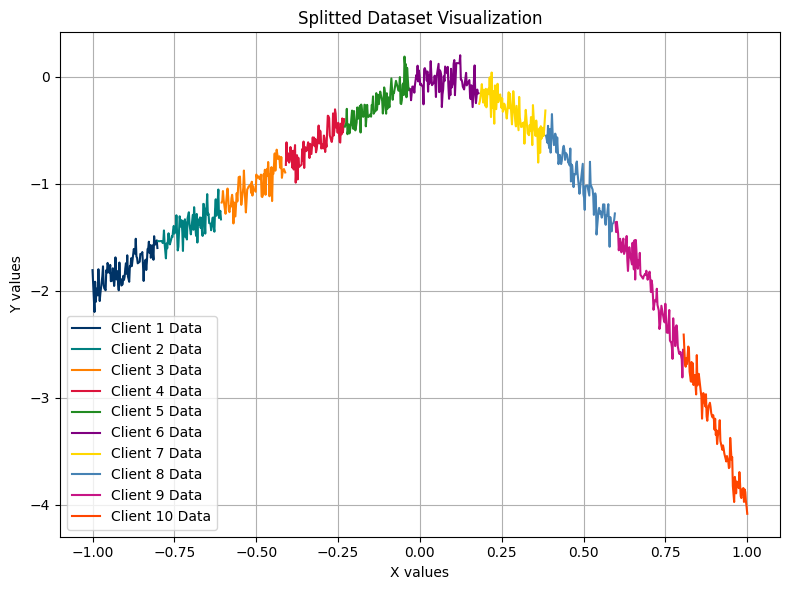

In [ ]:
model_name = f"SmartAttentionLayer_{NUM_CLIENTS}clients_{SPLIT_TYPE}-split"
writer = SummaryWriter(get_logging_dir(model_name, "artificial_1D_linear"))

clients = [
    SmartAttentionLayer.initialize_from_scratch(
        INPUT_FEATURES,
        OUTPUT_FEATURES,
        NUM_CLIENTS,
        client_id,
        PRED_ARCHITECTURE,
        INPUT_IMPRTNC_ARCHITECTURE,
        CLIENT_IMPRTNC_ARCHITECTURE,
        device=DEVICE,
    )
    for client_id in CLIENT_IDs
]

client_train_dataloaders = data.get_client_train_dataloaders(
    NUM_CLIENTS, SPLIT_TYPE, BATCH_SIZE, shuffle=True
)

plot_data_split(client_train_dataloaders, writer)

In [7]:
print(clients[0])

SmartAttentionLayer(
  (value_network): MultiOutputNet(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=5, bias=False)
      (1-3): 3 x Linear(in_features=6, out_features=5, bias=False)
    )
    (output_layers): ModuleList(
      (0-9): 10 x Linear(in_features=6, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
        (2): Parameter containing: [torch.float32 of size 1]
        (3): Parameter containing: [torch.float32 of size 1]
        (4): Parameter containing: [torch.float32 of size 1]
        (5): Parameter containing: [torch.float32 of size 1]
        (6): Parameter containing: [torch.float32 of size 1]
        (7): Parameter containing: [torch.float32 of size 1]
        (8): Parameter containing: [torch.float32 of size 1]
        (9): Parameter containing: [torch.float32 of size 1]
    )
  )
  (query_net

In [8]:
def is_cooling_off_epoch(cr: int):
    return cr > COMMUNICATION_ROUNDS // 2


for cr in range(COMMUNICATION_ROUNDS):
    # train each client individually
    for client_no, client in zip(CLIENT_IDs, clients):
        train_client(
            client_no=client_no,
            client_model=client,
            data_loader=client_train_dataloaders[client_no],
            loss_fn=LOSS_FN,
            no_epochs=CLIENT_EPOCHS,
            communication_round=cr,
            writer=writer,
            device=DEVICE,
        )

    register_client_test_losses(
        clients=clients,
        client_ids=CLIENT_IDs,
        writer=writer,
        communication_round=cr,
        device=DEVICE,
    )

    global_model = SmartAttentionLayer.get_global_model(
        clients,
        similarity_threshold_in_degree=SIMILARITY_THRESHOLD if not is_cooling_off_epoch(cr) else 181,
        method = "combine" if not is_cooling_off_epoch(cr) else "average"
    )
    global_model.to(DEVICE)

    writer.add_scalar("test_loss", evaluate(global_model, device=DEVICE), cr * CLIENT_EPOCHS)

    clients = [
        global_model.get_client_model(
            client_id, add_noise=(not is_cooling_off_epoch(cr))
        )
        for client_id in CLIENT_IDs
    ]

    #plot_predictions(global_model, model_name, writer, epoch=cr, device=DEVICE)

#plot_predictions(global_model, model_name, writer, device=DEVICE)
register_hyperparameters(writer, last_loss=evaluate(global_model))
writer.flush()
writer.close()

In [11]:
print(global_model)

SmartAttentionLayer(
  (value_network): MultiOutputNet(
    (hidden_layers): ModuleList(
      (0): Linear(in_features=2, out_features=11, bias=False)
      (1): Linear(in_features=12, out_features=30, bias=False)
      (2): Linear(in_features=31, out_features=18, bias=False)
      (3): Linear(in_features=19, out_features=29, bias=False)
    )
    (output_layers): ModuleList(
      (0-9): 10 x Linear(in_features=30, out_features=1, bias=False)
    )
    (output_scalings): ParameterList(
        (0): Parameter containing: [torch.float32 of size 1]
        (1): Parameter containing: [torch.float32 of size 1]
        (2): Parameter containing: [torch.float32 of size 1]
        (3): Parameter containing: [torch.float32 of size 1]
        (4): Parameter containing: [torch.float32 of size 1]
        (5): Parameter containing: [torch.float32 of size 1]
        (6): Parameter containing: [torch.float32 of size 1]
        (7): Parameter containing: [torch.float32 of size 1]
        (8): Paramet

In [9]:
print(global_model.query_network.full_representation())

SelfLearningNet Weights: (training on output None)
Layer 0 Weights:
[[ 0.95629823 -0.14905465]
 [-0.7657485   0.64314014]
 [ 0.4825634  -0.8372728 ]
 [-0.53077084 -0.85780764]
 [ 0.739377    0.6667827 ]
 [-0.5212288   0.85968095]
 [-0.9241645  -0.38199484]
 [-0.9423169   0.33472216]
 [ 0.6631743  -0.7002789 ]
 [ 1.004657    0.17231992]
 [ 0.5792599   0.8083394 ]
 [ 0.05264839 -1.1325356 ]]
Layer 1 Weights:
[[-8.27162147e-01 -2.41301328e-01 -2.49170512e-01 -1.44174322e-01
   2.63558179e-01  1.50718704e-01 -1.27575528e-02 -5.01365438e-02
   9.48341563e-02  2.25921255e-02  3.06714303e-03  4.53742743e-02
  -2.61092424e-01]
 [-5.14671743e-01  3.76501769e-01 -5.06026819e-02 -2.03095317e-01
  -2.48691529e-01 -6.55785143e-01 -1.90333705e-02  1.13087654e-01
  -7.42126629e-02 -2.61967033e-02  3.56972851e-02  1.89399615e-01
   3.33456956e-02]
 [ 2.64502198e-01  7.75672913e-01 -1.35340914e-01  8.75287205e-02
  -6.46556467e-02  2.69272089e-01 -8.82476419e-02  9.61341783e-02
   1.70022417e-02  2.051

In [10]:
for client in clients:
    print(client.prediction_network.full_representation())
    print(client.prediction_mask)

AttributeError: 'SmartAttentionLayer' object has no attribute 'prediction_network'